In [81]:
# LIBRARIES

import numpy as np                                                                   
import unicodedata                                                                   
import re                                                                            
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.nn.functional as F
from nltk.tokenize import TweetTokenizer
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from gensim.models import Word2Vec
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import json

In [82]:

class Preprocess:
    
    __word_embeddings = None
    __vector_dimension = None

    __data_normalization = None
    __normalization_parameters = None
    
    __parties_to_numbers = {'ND' : 1.0, 'SYRIZA' : 2.0, 'PASOK' : 3.0, 'KKE' : 4.0, 'DIEM' : 5.0, 'ELL_LYSI' : 6.0}
    __sentiments_to_numbers = {'POSITIVE': 0, 'NEUTRAL': 1, 'NEGATIVE': 2}
    __numbers_to_sentiments = {0 : 'POSITIVE' , 1 : 'NEUTRAL', 2 : 'NEGATIVE'}
    
    __stopwords = ['Α', 'ΑΔΙΑΚΟΠΑ', 'ΑΙ', 'ΑΚΟΜΑ', 'ΑΚΟΜΗ', 'ΑΚΡΙΒΩΣ', 'ΑΛΗΘΕΙΑ', 'ΑΛΗΘΙΝΑ', 'ΑΛΛΑ', 'ΑΛΛΑΧΟΥ', 'ΑΛΛΕΣ', 'ΑΛΛΗ', 'ΑΛΛΗΝ', 'ΑΛΛΗΣ', 'ΑΛΛΙΩΣ', 'ΑΛΛΙΩΤΙΚΑ', 'ΑΛΛΟ', 'ΑΛΛΟΙ', 'ΑΛΛΟΙΩΣ', 'ΑΛΛΟΙΩΤΙΚΑ', 'ΑΛΛΟΝ', 'ΑΛΛΟΣ', 'ΑΛΛΟΤΕ', 'ΑΛΛΟΥ', 'ΑΛΛΟΥΣ', 'ΑΛΛΩΝ', 'ΑΜΑ', 'ΑΜΕΣΑ', 'ΑΜΕΣΩΣ', 'ΑΝ', 'ΑΝΑ', 'ΑΝΑΜΕΣΑ', 'ΑΝΑΜΕΤΑΞΥ', 'ΑΝΕΥ', 'ΑΝΤΙ', 'ΑΝΤΙΠΕΡΑ', 'ΑΝΤΙΣ', 'ΑΝΩ', 'ΑΝΩΤΕΡΩ', 'ΑΞΑΦΝΑ', 'ΑΠ', 'ΑΠΕΝΑΝΤΙ', 'ΑΠΟ', 'ΑΠΟΨΕ', 'ΑΡΑ', 'ΑΡΑΓΕ', 'ΑΡΓΑ', 'ΑΡΓΟΤΕΡΟ', 'ΑΡΙΣΤΕΡΑ', 'ΑΡΚΕΤΑ', 'ΑΡΧΙΚΑ', 'ΑΣ', 'ΑΥΡΙΟ', 'ΑΥΤΑ', 'ΑΥΤΕΣ', 'ΑΥΤΗ', 'ΑΥΤΗΝ', 'ΑΥΤΗΣ', 'ΑΥΤΟ', 'ΑΥΤΟΙ', 'ΑΥΤΟΝ', 'ΑΥΤΟΣ', 'ΑΥΤΟΥ', 'ΑΥΤΟΥΣ', 'ΑΥΤΩΝ', 'ΑΦΟΤΟΥ', 'ΑΦΟΥ', 'Β', 'ΒΕΒΑΙΑ', 'ΒΕΒΑΙΟΤΑΤΑ', 'Γ', 'ΓΙ', 'ΓΙΑ', 'ΓΙΑΤΙ', 'ΓΡΗΓΟΡΑ', 'ΓΥΡΩ', 'Δ', 'ΔΑ', 'ΔΕ', 'ΔΕΝ', 'ΔΕΙΝΑ', 'ΔΕΞΙΑ', 'ΔΗΘΕΝ', 'ΔΗΛΑΔΗ', 'ΔΙ', 'ΔΙΑ', 'ΔΙΑΡΚΩΣ', 'ΔΙΚΑ', 'ΔΙΚΟ', 'ΔΙΚΟΙ', 'ΔΙΚΟΣ', 'ΔΙΚΟΥ', 'ΔΙΚΟΥΣ', 'ΔΙΟΛΟΥ', 'ΔΙΠΛΑ', 'ΔΙΧΩΣ', 'Ε', 'ΕΑΝ', 'ΕΑΥΤΟ', 'ΕΑΥΤΟΝ', 'ΕΑΥΤΟΥ', 'ΕΑΥΤΟΥΣ', 'ΕΑΥΤΩΝ', 'ΕΓΚΑΙΡΑ', 'ΕΓΚΑΙΡΩΣ', 'ΕΓΩ', 'ΕΔΩ', 'ΕΙΔΕΜΗ', 'ΕΙΘΕ', 'ΕΙΜΑΙ', 'ΕΙΜΑΣΤΕ', 'ΕΙΝΑΙ', 'ΕΙΣ', 'ΕΙΣΑΙ', 'ΕΙΣΑΣΤΕ', 'ΕΙΣΤΕ', 'ΕΙΤΕ', 'ΕΙΧΑ', 'ΕΙΧΑΜΕ', 'ΕΙΧΑΝ', 'ΕΙΧΑΤΕ', 'ΕΙΧΕ', 'ΕΙΧΕΣ', 'ΕΚΑΣΤΑ', 'ΕΚΑΣΤΕΣ', 'ΕΚΑΣΤΗ', 'ΕΚΑΣΤΗΝ', 'ΕΚΑΣΤΗΣ', 'ΕΚΑΣΤΟ', 'ΕΚΑΣΤΟΙ', 'ΕΚΑΣΤΟΝ', 'ΕΚΑΣΤΟΣ', 'ΕΚΑΣΤΟΥ', 'ΕΚΑΣΤΟΥΣ', 'ΕΚΑΣΤΩΝ', 'ΕΚΕΙ', 'ΕΚΕΙΝΑ', 'ΕΚΕΙΝΕΣ', 'ΕΚΕΙΝΗ', 'ΕΚΕΙΝΗΝ', 'ΕΚΕΙΝΗΣ', 'ΕΚΕΙΝΟ', 'ΕΚΕΙΝΟΙ', 'ΕΚΕΙΝΟΝ', 'ΕΚΕΙΝΟΣ', 'ΕΚΕΙΝΟΥ', 'ΕΚΕΙΝΟΥΣ', 'ΕΚΕΙΝΩΝ', 'ΕΚΤΟΣ', 'ΕΜΑΣ', 'ΕΜΕΙΣ', 'ΕΜΕΝΑ', 'ΕΜΠΡΟΣ', 'ΕΝ', 'ΕΝΑ', 'ΕΝΑΝ', 'ΕΝΑΣ', 'ΕΝΟΣ', 'ΕΝΤΕΛΩΣ', 'ΕΝΤΟΣ', 'ΕΝΤΩΜΕΤΑΞΥ', 'ΕΝΩ', 'ΕΞ', 'ΕΞΑΦΝΑ', 'ΕΞΗΣ', 'ΕΞΙΣΟΥ', 'ΕΞΩ', 'ΕΠΑΝΩ', 'ΕΠΕΙΔΗ', 'ΕΠΕΙΤΑ', 'ΕΠΙ', 'ΕΠΙΣΗΣ', 'ΕΠΟΜΕΝΩΣ', 'ΕΣΑΣ', 'ΕΣΕΙΣ', 'ΕΣΕΝΑ', 'ΕΣΤΩ', 'ΕΣΥ', 'ΕΤΕΡΑ', 'ΕΤΕΡΑΙ', 'ΕΤΕΡΑΣ', 'ΕΤΕΡΕΣ', 'ΕΤΕΡΗ', 'ΕΤΕΡΗΣ', 'ΕΤΕΡΟ', 'ΕΤΕΡΟΙ', 'ΕΤΕΡΟΝ', 'ΕΤΕΡΟΣ', 'ΕΤΕΡΟΥ', 'ΕΤΕΡΟΥΣ', 'ΕΤΕΡΩΝ', 'ΕΤΟΥΤΑ', 'ΕΤΟΥΤΕΣ', 'ΕΤΟΥΤΗ', 'ΕΤΟΥΤΗΝ', 'ΕΤΟΥΤΗΣ', 'ΕΤΟΥΤΟ', 'ΕΤΟΥΤΟΙ', 'ΕΤΟΥΤΟΝ', 'ΕΤΟΥΤΟΣ', 'ΕΤΟΥΤΟΥ', 'ΕΤΟΥΤΟΥΣ', 'ΕΤΟΥΤΩΝ', 'ΕΤΣΙ', 'ΕΥΓΕ', 'ΕΥΘΥΣ', 'ΕΥΤΥΧΩΣ', 'ΕΦΕΞΗΣ', 'ΕΧΕΙ', 'ΕΧΕΙΣ', 'ΕΧΕΤΕ', 'ΕΧΘΕΣ', 'ΕΧΟΜΕ', 'ΕΧΟΥΜΕ', 'ΕΧΟΥΝ', 'ΕΧΤΕΣ', 'ΕΧΩ', 'ΕΩΣ', 'Ζ', 'Η', 'ΗΔΗ', 'ΗΜΑΣΤΑΝ', 'ΗΜΑΣΤΕ', 'ΗΜΟΥΝ', 'ΗΣΑΣΤΑΝ', 'ΗΣΑΣΤΕ', 'ΗΣΟΥΝ', 'ΗΤΑΝ', 'ΗΤΑΝΕ', 'ΗΤΟΙ', 'ΗΤΤΟΝ', 'Θ', 'ΘΑ', 'Ι', 'ΙΔΙΑ', 'ΙΔΙΑΝ', 'ΙΔΙΑΣ', 'ΙΔΙΕΣ', 'ΙΔΙΟ', 'ΙΔΙΟΙ', 'ΙΔΙΟΝ', 'ΙΔΙΟΣ', 'ΙΔΙΟΥ', 'ΙΔΙΟΥΣ', 'ΙΔΙΩΝ', 'ΙΔΙΩΣ', 'ΙΙ', 'ΙΙΙ', 'ΙΣΑΜΕ', 'ΙΣΙΑ', 'ΙΣΩΣ', 'Κ', 'ΚΑΘΕ', 'ΚΑΘΕΜΙΑ', 'ΚΑΘΕΜΙΑΣ', 'ΚΑΘΕΝΑ', 'ΚΑΘΕΝΑΣ', 'ΚΑΘΕΝΟΣ', 'ΚΑΘΕΤΙ', 'ΚΑΘΟΛΟΥ', 'ΚΑΘΩΣ', 'ΚΑΙ', 'ΚΑΚΑ', 'ΚΑΚΩΣ', 'ΚΑΛΑ', 'ΚΑΛΩΣ', 'ΚΑΜΙΑ', 'ΚΑΜΙΑΝ', 'ΚΑΜΙΑΣ', 'ΚΑΜΠΟΣΑ', 'ΚΑΜΠΟΣΕΣ', 'ΚΑΜΠΟΣΗ', 'ΚΑΜΠΟΣΗΝ', 'ΚΑΜΠΟΣΗΣ', 'ΚΑΜΠΟΣΟ', 'ΚΑΜΠΟΣΟΙ', 'ΚΑΜΠΟΣΟΝ', 'ΚΑΜΠΟΣΟΣ', 'ΚΑΜΠΟΣΟΥ', 'ΚΑΜΠΟΣΟΥΣ', 'ΚΑΜΠΟΣΩΝ', 'ΚΑΝΕΙΣ', 'ΚΑΝΕΝ', 'ΚΑΝΕΝΑ', 'ΚΑΝΕΝΑΝ', 'ΚΑΝΕΝΑΣ', 'ΚΑΝΕΝΟΣ', 'ΚΑΠΟΙΑ', 'ΚΑΠΟΙΑΝ', 'ΚΑΠΟΙΑΣ', 'ΚΑΠΟΙΕΣ', 'ΚΑΠΟΙΟ', 'ΚΑΠΟΙΟΙ', 'ΚΑΠΟΙΟΝ', 'ΚΑΠΟΙΟΣ', 'ΚΑΠΟΙΟΥ', 'ΚΑΠΟΙΟΥΣ', 'ΚΑΠΟΙΩΝ', 'ΚΑΠΟΤΕ', 'ΚΑΠΟΥ', 'ΚΑΠΩΣ', 'ΚΑΤ', 'ΚΑΤΑ', 'ΚΑΤΙ', 'ΚΑΤΙΤΙ', 'ΚΑΤΟΠΙΝ', 'ΚΑΤΩ', 'ΚΙ', 'ΚΙΟΛΑΣ', 'ΚΛΠ', 'ΚΟΝΤΑ', 'ΚΤΛ', 'ΚΥΡΙΩΣ', 'Λ', 'ΛΙΓΑΚΙ', 'ΛΙΓΟ', 'ΛΙΓΩΤΕΡΟ', 'ΛΟΓΩ', 'ΛΟΙΠΑ', 'ΛΟΙΠΟΝ', 'Μ', 'ΜΑ', 'ΜΑΖΙ', 'ΜΑΚΑΡΙ', 'ΜΑΚΡΥΑ', 'ΜΑΛΙΣΤΑ', 'ΜΑΛΛΟΝ', 'ΜΑΣ', 'ΜΕ', 'ΜΕΘΑΥΡΙΟ', 'ΜΕΙΟΝ', 'ΜΕΛΕΙ', 'ΜΕΛΛΕΤΑΙ', 'ΜΕΜΙΑΣ', 'ΜΕΝ', 'ΜΕΡΙΚΑ', 'ΜΕΡΙΚΕΣ', 'ΜΕΡΙΚΟΙ', 'ΜΕΡΙΚΟΥΣ', 'ΜΕΡΙΚΩΝ', 'ΜΕΣΑ', 'ΜΕΤ', 'ΜΕΤΑ', 'ΜΕΤΑΞΥ', 'ΜΕΧΡΙ', 'ΜΗ', 'ΜΗΔΕ', 'ΜΗΝ', 'ΜΗΠΩΣ', 'ΜΗΤΕ', 'ΜΙΑ', 'ΜΙΑΝ', 'ΜΙΑΣ', 'ΜΟΛΙΣ', 'ΜΟΛΟΝΟΤΙ', 'ΜΟΝΑΧΑ', 'ΜΟΝΕΣ', 'ΜΟΝΗ', 'ΜΟΝΗΝ', 'ΜΟΝΗΣ', 'ΜΟΝΟ', 'ΜΟΝΟΙ', 'ΜΟΝΟΜΙΑΣ', 'ΜΟΝΟΣ', 'ΜΟΝΟΥ', 'ΜΟΝΟΥΣ', 'ΜΟΝΩΝ', 'ΜΟΥ', 'ΜΠΟΡΕΙ', 'ΜΠΟΡΟΥΝ', 'ΜΠΡΑΒΟ', 'ΜΠΡΟΣ', 'Ν', 'ΝΑ', 'ΝΑΙ', 'ΝΩΡΙΣ', 'Ξ', 'ΞΑΝΑ', 'ΞΑΦΝΙΚΑ', 'Ο', 'ΟΙ', 'ΟΛΑ', 'ΟΛΕΣ', 'ΟΛΗ', 'ΟΛΗΝ', 'ΟΛΗΣ', 'ΟΛΟ', 'ΟΛΟΓΥΡΑ', 'ΟΛΟΙ', 'ΟΛΟΝ', 'ΟΛΟΝΕΝ', 'ΟΛΟΣ', 'ΟΛΟΤΕΛΑ', 'ΟΛΟΥ', 'ΟΛΟΥΣ', 'ΟΛΩΝ', 'ΟΛΩΣ', 'ΟΛΩΣΔΙΟΛΟΥ', 'ΟΜΩΣ', 'ΟΠΟΙΑ', 'ΟΠΟΙΑΔΗΠΟΤΕ', 'ΟΠΟΙΑΝ', 'ΟΠΟΙΑΝΔΗΠΟΤΕ', 'ΟΠΟΙΑΣ', 'ΟΠΟΙΑΣΔΗΠΟΤΕ', 'ΟΠΟΙΔΗΠΟΤΕ', 'ΟΠΟΙΕΣ', 'ΟΠΟΙΕΣΔΗΠΟΤΕ', 'ΟΠΟΙΟ', 'ΟΠΟΙΟΔΗΠΟΤΕ', 'ΟΠΟΙΟΙ', 'ΟΠΟΙΟΝ', 'ΟΠΟΙΟΝΔΗΠΟΤΕ', 'ΟΠΟΙΟΣ', 'ΟΠΟΙΟΣΔΗΠΟΤΕ', 'ΟΠΟΙΟΥ', 'ΟΠΟΙΟΥΔΗΠΟΤΕ', 'ΟΠΟΙΟΥΣ', 'ΟΠΟΙΟΥΣΔΗΠΟΤΕ', 'ΟΠΟΙΩΝ', 'ΟΠΟΙΩΝΔΗΠΟΤΕ', 'ΟΠΟΤΕ', 'ΟΠΟΤΕΔΗΠΟΤΕ', 'ΟΠΟΥ', 'ΟΠΟΥΔΗΠΟΤΕ', 'ΟΠΩΣ', 'ΟΡΙΣΜΕΝΑ', 'ΟΡΙΣΜΕΝΕΣ', 'ΟΡΙΣΜΕΝΩΝ', 'ΟΡΙΣΜΕΝΩΣ', 'ΟΣΑ', 'ΟΣΑΔΗΠΟΤΕ', 'ΟΣΕΣ', 'ΟΣΕΣΔΗΠΟΤΕ', 'ΟΣΗ', 'ΟΣΗΔΗΠΟΤΕ', 'ΟΣΗΝ', 'ΟΣΗΝΔΗΠΟΤΕ', 'ΟΣΗΣ', 'ΟΣΗΣΔΗΠΟΤΕ', 'ΟΣΟ', 'ΟΣΟΔΗΠΟΤΕ', 'ΟΣΟΙ', 'ΟΣΟΙΔΗΠΟΤΕ', 'ΟΣΟΝ', 'ΟΣΟΝΔΗΠΟΤΕ', 'ΟΣΟΣ', 'ΟΣΟΣΔΗΠΟΤΕ', 'ΟΣΟΥ', 'ΟΣΟΥΔΗΠΟΤΕ', 'ΟΣΟΥΣ', 'ΟΣΟΥΣΔΗΠΟΤΕ', 'ΟΣΩΝ', 'ΟΣΩΝΔΗΠΟΤΕ', 'ΟΤΑΝ', 'ΟΤΙ', 'ΟΤΙΔΗΠΟΤΕ', 'ΟΤΟΥ', 'ΟΥ', 'ΟΥΔΕ', 'ΟΥΤΕ', 'ΟΧΙ', 'Π', 'ΠΑΛΙ', 'ΠΑΝΤΟΤΕ', 'ΠΑΝΤΟΥ', 'ΠΑΝΤΩΣ', 'ΠΑΡΑ', 'ΠΕΡΑ', 'ΠΕΡΙ', 'ΠΕΡΙΠΟΥ', 'ΠΕΡΙΣΣΟΤΕΡΟ', 'ΠΕΡΣΙ', 'ΠΕΡΥΣΙ', 'ΠΙΑ', 'ΠΙΘΑΝΟΝ', 'ΠΙΟ', 'ΠΙΣΩ', 'ΠΛΑΙ', 'ΠΛΕΟΝ', 'ΠΛΗΝ', 'ΠΟΙΑ', 'ΠΟΙΑΝ', 'ΠΟΙΑΣ', 'ΠΟΙΕΣ', 'ΠΟΙΟ', 'ΠΟΙΟΙ', 'ΠΟΙΟΝ', 'ΠΟΙΟΣ', 'ΠΟΙΟΥ', 'ΠΟΙΟΥΣ', 'ΠΟΙΩΝ', 'ΠΟΛΥ', 'ΠΟΣΕΣ', 'ΠΟΣΗ', 'ΠΟΣΗΝ', 'ΠΟΣΗΣ', 'ΠΟΣΟΙ', 'ΠΟΣΟΣ', 'ΠΟΣΟΥΣ', 'ΠΟΤΕ', 'ΠΟΥ', 'ΠΟΥΘΕ', 'ΠΟΥΘΕΝΑ', 'ΠΡΕΠΕΙ', 'ΠΡΙΝ', 'ΠΡΟ', 'ΠΡΟΚΕΙΜΕΝΟΥ', 'ΠΡΟΚΕΙΤΑΙ', 'ΠΡΟΠΕΡΣΙ', 'ΠΡΟΣ', 'ΠΡΟΤΟΥ', 'ΠΡΟΧΘΕΣ', 'ΠΡΟΧΤΕΣ', 'ΠΡΩΤΥΤΕΡΑ', 'ΠΩΣ', 'ΡΕ', 'Σ', 'ΣΑΝ', 'ΣΑΣ', 'ΣΕ', 'ΣΕΙΣ', 'ΣΗΜΕΡΑ', 'ΣΙΓΑ', 'ΣΟΥ', 'ΣΤΑ', 'ΣΤΗ', 'ΣΤΗΝ', 'ΣΤΗΣ', 'ΣΤΙΣ', 'ΣΤΟ', 'ΣΤΟΝ', 'ΣΤΟΥ', 'ΣΤΟΥΣ', 'ΣΤΩΝ', 'ΣΥΓΧΡΟΝΩΣ', 'ΣΥΝ', 'ΣΥΝΑΜΑ', 'ΣΥΝΕΠΩΣ', 'ΣΥΝΗΘΩΣ', 'ΣΥΧΝΑ', 'ΣΥΧΝΑΣ', 'ΣΥΧΝΕΣ', 'ΣΥΧΝΗ', 'ΣΥΧΝΗΝ', 'ΣΥΧΝΗΣ', 'ΣΥΧΝΟ', 'ΣΥΧΝΟΙ', 'ΣΥΧΝΟΝ', 'ΣΥΧΝΟΣ', 'ΣΥΧΝΟΥ', 'ΣΥΧΝΟΥΣ', 'ΣΥΧΝΩΝ', 'ΣΥΧΝΩΣ', 'ΣΧΕΔΟΝ', 'ΣΩΣΤΑ', 'Τ', 'ΤΑ', 'ΤΑΔΕ', 'ΤΑΥΤΑ', 'ΤΑΥΤΕΣ', 'ΤΑΥΤΗ', 'ΤΑΥΤΗΝ', 'ΤΑΥΤΗΣ', 'ΤΑΥΤΟ', 'ΤΑΥΤΟΝ', 'ΤΑΥΤΟΣ', 'ΤΑΥΤΟΥ', 'ΤΑΥΤΩΝ', 'ΤΑΧΑ', 'ΤΑΧΑΤΕ', 'ΤΕΛΙΚΑ', 'ΤΕΛΙΚΩΣ', 'ΤΕΣ', 'ΤΕΤΟΙΑ', 'ΤΕΤΟΙΑΝ', 'ΤΕΤΟΙΑΣ', 'ΤΕΤΟΙΕΣ', 'ΤΕΤΟΙΟ', 'ΤΕΤΟΙΟΙ', 'ΤΕΤΟΙΟΝ', 'ΤΕΤΟΙΟΣ', 'ΤΕΤΟΙΟΥ', 'ΤΕΤΟΙΟΥΣ', 'ΤΕΤΟΙΩΝ', 'ΤΗ', 'ΤΗΝ', 'ΤΗΣ', 'ΤΙ', 'ΤΙΠΟΤΑ', 'ΤΙΠΟΤΕ', 'ΤΙΣ', 'ΤΟ', 'ΤΟΙ', 'ΤΟΝ', 'ΤΟΣ', 'ΤΟΣΑ', 'ΤΟΣΕΣ', 'ΤΟΣΗ', 'ΤΟΣΗΝ', 'ΤΟΣΗΣ', 'ΤΟΣΟ', 'ΤΟΣΟΙ', 'ΤΟΣΟΝ', 'ΤΟΣΟΣ', 'ΤΟΣΟΥ', 'ΤΟΣΟΥΣ', 'ΤΟΣΩΝ', 'ΤΟΤΕ', 'ΤΟΥ', 'ΤΟΥΛΑΧΙΣΤΟ', 'ΤΟΥΛΑΧΙΣΤΟΝ', 'ΤΟΥΣ', 'ΤΟΥΤΑ', 'ΤΟΥΤΕΣ', 'ΤΟΥΤΗ', 'ΤΟΥΤΗΝ', 'ΤΟΥΤΗΣ', 'ΤΟΥΤΟ', 'ΤΟΥΤΟΙ', 'ΤΟΥΤΟΙΣ', 'ΤΟΥΤΟΝ', 'ΤΟΥΤΟΣ', 'ΤΟΥΤΟΥ', 'ΤΟΥΤΟΥΣ', 'ΤΟΥΤΩΝ', 'ΤΥΧΟΝ', 'ΤΩΝ', 'ΤΩΡΑ', 'Υ', 'ΥΠ', 'ΥΠΕΡ', 'ΥΠΟ', 'ΥΠΟΨΗ', 'ΥΠΟΨΙΝ', 'ΥΣΤΕΡΑ', 'Φ', 'ΦΕΤΟΣ', 'Χ', 'ΧΑΜΗΛΑ', 'ΧΘΕΣ', 'ΧΤΕΣ', 'ΧΩΡΙΣ', 'ΧΩΡΙΣΤΑ', 'Ψ', 'ΨΗΛΑ', 'Ω', 'ΩΡΑΙΑ', 'ΩΣ', 'ΩΣΑΝ', 'ΩΣΟΤΟΥ', 'ΩΣΠΟΥ', 'ΩΣΤΕ', 'ΩΣΤΟΣΟ', 'ΩΧ']
    
    
    __tokenizer = TweetTokenizer(reduce_len=True)
    
    __clean_URLs = True
    __clean_user_mentions = True
    __clean_hashtags = False
    __clean_symbols_only = False
    __to_uppercase = True
    __clean_stopwords = True
    __clean_intonations = True
    __clean_special_characters = True
    __clean_endings = True
    
    __url_regex = re.compile(r'(http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)|(www\.[^ \s]+)')
    __user_mention_regex = re.compile(r'@\w+')
    __hashtag_regex = re.compile(r'#\S+')
    
    def __init__(self,word_embeddings_url, normalization_type):
        self.__load_word_embeddings(word_embeddings_url)
        self.__data_normalization = normalization_type        
    
    def __load_word_embeddings(self, filename):
        model = Word2Vec.load(filename)
        self.__word_embeddings = model.wv
        self.__vector_dimension = model.vector_size
        return

    def __load_dataset(self,dataset_url):
        dataframe = pd.read_csv(dataset_url)
        return dataframe
    
    def __tokenize(self,tweet):
        tokens = self.__tokenizer.tokenize(tweet)
        return tokens
    
    def __remove_URLs(self,tokens):
        final_tokens = []
        for token in tokens:
            if not self.__url_regex.match(token):
                final_tokens.append(token)
        return final_tokens
    
    def __remove_user_mentions(self,tokens):
        final_tokens = []
        for token in tokens:
            if not self.__user_mention_regex.match(token):
                final_tokens.append(token)
        return final_tokens
    
    def __remove_intonations(self,tokens):
        final_tokens = []
        for token in tokens:
            # Break down the token into normal characters and their respective intonations
            transformed_token = unicodedata.normalize('NFD', token)
            final_token = ''
            for character in transformed_token:
                # If the character is not an intonation, add it to the final token
                if not unicodedata.combining(character):
                    final_token += character
            final_tokens.append(final_token)
        return final_tokens
    
    def __convert_to_uppercase(self,tokens):
        final_tokens = []
        for token in tokens:
            # Convert each token to uppercase
            uppercase_token = token.upper()
            final_tokens.append(uppercase_token)
        return final_tokens
    
    def __remove_hashtags(self,tokens):
        final_tokens = []
        if self.__clean_symbols_only:
            for token in tokens:
                no_hashtag_token = token.replace('#', '')
                final_tokens.append(no_hashtag_token)
        else:
            for token in tokens:
                if not self.__hashtag_regex.match(token):
                    final_tokens.append(token)
        return final_tokens
    
    def __remove_special_characters(self,tokens):
        final_tokens = []
        for token in tokens:
            final_token = ''
            for i, character in enumerate(token):
                if i == 0 :
                    if character == "#" :
                        final_token += character
                    else :
                        if character.isalpha():
                            final_token += character
                else :
                    if character.isalpha():
                        final_token += character
            final_tokens.append(final_token)
        return final_tokens
    
    def __remove_stopwords(self,tokens):
        final_tokens = []
        for token in tokens:
            if token not in self.__stopwords:
                final_tokens.append(token)
        return final_tokens
    
    def __remove_endings(self,tokens):
        final_tokens = []
        for token in tokens:
            if token and (token[-1] == "Σ" or token[-1] == "Ν"):
                token = token[:-1]
            final_tokens.append(token)
        return final_tokens

    def __remove_spaces(self,tokens):
        final_tokens = []
        for token in tokens:
            final_token = token.replace(" ","")
            final_tokens.append(final_token)
        return final_tokens

    def __remove_short_tokens(self,tokens):
        final_tokens = []
        for token in tokens:
            if len(token) > 1:
                final_tokens.append(token)
        return final_tokens

    def __clean_tweet(self,tweet):

        tokens = self.__tokenize(tweet)
        
        if self.__clean_URLs:
            tokens = self.__remove_URLs(tokens)
        
        if self.__clean_user_mentions:
            tokens = self.__remove_user_mentions(tokens)
            
        if self.__clean_intonations:
            tokens = self.__remove_intonations(tokens)    
            
        if self.__to_uppercase:
            tokens = self.__convert_to_uppercase(tokens)
            
        if self.__clean_hashtags:
            tokens = self.__remove_hashtags(tokens)
            
        if self.__clean_special_characters:
            tokens = self.__remove_special_characters(tokens)
        
        if self.__clean_stopwords:
            tokens = self.__remove_stopwords(tokens)
         
        if self.__clean_endings:
            tokens = self.__remove_endings(tokens) 
         
        tokens = self.__remove_spaces(tokens)
        
        tokens = self.__remove_short_tokens(tokens)
        
        return tokens

    def __clean_dataset(self,dataset):
        
        clean_tweets = []
        
        for i, row in dataset.iterrows():
            
            tweet = row['Text']
            
            clean_tweet = self.__clean_tweet(tweet)
            
            clean_tweets.append(clean_tweet)
            
        self.__write_dataset(clean_tweets)    
            
        return clean_tweets
    
    def __write_dataset(self,clean_tweets):
        with open("text8", "w", encoding='utf-8') as file:
            for tweet in clean_tweets:
                file.write(" ".join(tweet) + "\n")  
        return
    
    def __encode_parties(self, parties):
        encoded_parties = []
        for party in parties:
            encoded_party = self.__parties_to_numbers.get(party, 0.0)
            encoded_parties.append(encoded_party)
        encoded_parties = torch.tensor(encoded_parties, dtype=torch.float32)
        return encoded_parties
    
    # public for test set 
    def encode_sentiments(self, sentiments, to_numbers=True):
        mapping = self.__sentiments_to_numbers if to_numbers else self.__numbers_to_sentiments
        encoded_sentiments = [mapping[sentiment] for sentiment in sentiments]  # Directly use the sentiment value for lookup
        return encoded_sentiments


    def __extract_features(self, clean_tweets, parties, average = True):
        
        
        # Encode political parties
        encoded_parties = self.__encode_parties(parties)
    
        # Initialize the features tensor for all tweets with additional space for party encodings
        features = torch.zeros(len(clean_tweets), self.__vector_dimension + 1, dtype=torch.float32)
    
        # Iterate over the cleaned tweets to compute the feature representation
        for i, tweet in enumerate(clean_tweets):
            accumulative_embedding = torch.zeros(self.__vector_dimension, dtype=torch.float32)
            words_count = 0
    
            # Aggregate the embeddings of the words found in the tweet
            for word in tweet:
                if word in self.__word_embeddings:
                    word_embedding = torch.tensor(self.__word_embeddings[word], dtype=torch.float32)
                    accumulative_embedding += word_embedding
                    words_count += 1
    
            # Calculate the average embedding for the tweet if any words were found
            if average:
                if words_count > 0:
                    accumulative_embedding /= words_count
    
            # Combine the average word embedding with the encoded party information
            features[i, :-1] = accumulative_embedding
            features[i, -1] = encoded_parties[i]
    
    
    
        return features
    
    def __normalize_features(self,features):
        if self.__data_normalization == "standardization" :
            self.__standardization(features)
        elif self.__data_normalization == "min_max_scaling" :
            self.__min_max_scaling(features)
    
    def __standardization(self, features):
        
        if self.__normalization_parameters is None:
            # Calculate mean and standard deviation using PyTorch
            means = torch.mean(features[:, :-1], dim=0)
            stds = torch.std(features[:, :-1], dim=0)

            # Avoid division by zero for constant features
            stds[stds == 0] = 1

            self.__normalization_parameters = (means, stds)

        else:
            # Retrieve stored means and standard deviations
            means, stds = self.__normalization_parameters

        # Apply standardization
        features[:, :-1] = (features[:, :-1] - means) / stds

    def __min_max_scaling(self, features):
        
        if self.__normalization_parameters is None:
            # Use torch.min and torch.max
            mins = torch.min(features[:, :-1], dim=0).values
            maxs = torch.max(features[:, :-1], dim=0).values

            maxs_mins_diff = maxs - mins
            # Avoid division by zero for constant features
            maxs_mins_diff[maxs_mins_diff == 0] = 1

            self.__normalization_parameters = (mins, maxs)
            features[:, :-1] = (features[:, :-1] - mins) / maxs_mins_diff
        else:
            mins, maxs = self.__normalization_parameters
            maxs_mins_diff = maxs - mins
            features[:, :-1] = (features[:, :-1] - mins) / maxs_mins_diff
            
        # Divide the last column by 6
        features[:, -1] /= 6.0
        
    def __extract_labels(self,sentiments):
        labels = self.encode_sentiments(sentiments)
        return labels
    
    def get_input_size(self):
        if self.__vector_dimension is None:
            return None
        return self.__vector_dimension + 1
    
    def preprocess_dataset(self,dataset_URL,aggregation):
        
        dataset = self.__load_dataset(dataset_URL)
        clean_tweets = self.__clean_dataset(dataset)
        average = True if aggregation == "average" else False
        features = self.__extract_features(clean_tweets,dataset['Party'],average)
        self.__normalize_features(features)
        
        labels = torch.zeros(len(features), dtype=torch.long)
        if 'Sentiment' in dataset.columns:
            labels = self.__extract_labels(dataset['Sentiment'])
            
        dataset = CustomDataset(features,labels)
            
        return dataset
    

In [83]:
class CustomDataset(Dataset):
    
    def __init__(self, features, labels=None):        
        self.__features = features
        self.__labels = labels

    def __len__(self):
        return len(self.__features)

    def __getitem__(self, index):
        instance_features = self.__features[index]
        instance_label = None
        if self.__labels is not None:
            instance_label = self.__labels[index]
        return (instance_features,instance_label)

    def get_features(self):
        return self.__features
    
    def get_labels(self):
        return self.__labels

In [84]:

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size, model_parameters):
    
        super(NeuralNetwork, self).__init__()
        
        layers = model_parameters['layers']
        neurons = model_parameters['neurons']
        activations = model_parameters['activations']
        dropouts = model_parameters['dropouts']
        
        network_layers = []
        input_neurons = input_size
        
        for i in range(len(layers)):
            
            output_neurons = neurons[i]
            
            if layers[i] == "linear" :
                network_layers.append(nn.Linear(input_neurons,output_neurons))
            # elif : in case another LAYER type except linear is specified
            
            if activations[i] == "relu" :
                network_layers.append(nn.ReLU())
            elif activations[i] == "sigmoid":
                network_layers.append(nn.Sigmoid())
            # elif : in case another ACTIVATION type except relu or sigmoid is specified
            
            if dropouts[i] > 0.0 :
                network_layers.append(nn.Dropout(dropouts[i]))
        
            input_neurons = output_neurons
            
        self.__neural_network = nn.Sequential(*network_layers)
        self.__neural_network_str = str(self.__neural_network)
    
    def forward(self, batch):
        network_output = self.__neural_network(batch)
        return network_output
        
    def train_model(self, train_loader, valid_loader, train_parameters):
        
        # PARAMETERS
        epochs = train_parameters['epochs']
        regularization_strength = train_parameters['regularization_strength']
        alpha = train_parameters['alpha']
        early_stopping = train_parameters['early_stopping']
        patience = train_parameters['patience']
        loss_function_name = train_parameters['loss_function']
        optimizer_name = train_parameters['optimizer']
        scheduler_name = train_parameters['scheduler']
        learning_rate = train_parameters['learning_rate']
        gamma = train_parameters['gamma']
        step_size = train_parameters['step_size']
        average = train_parameters['average']
        
        if loss_function_name == 'cross_entropy' :
            loss_function = nn.CrossEntropyLoss(reduction='mean')
        
        if optimizer_name == 'Adam' :
            optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'SGD' :
            optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        elif optimizer_name == 'ASGD' :
            optimizer = torch.optim.ASGD(self.parameters(), lr=learning_rate)
        
        scheduler = None
        if scheduler_name == 'ExponentialLR' :
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == 'StepLR' :
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        
        # BEST MODEL
        
        best_model = None
        minimum_custom_metric_value = float('inf')
        # The weights of the custom metric
        
        # For calculating best model's confusion matrix and ROC curves on the validation set
        best_model_valid_labels = []
        best_model_class_predictions = []
        best_model_probabilities = []
        
        # For avoiding re-calculating the metrics of the best model on the validation set
        best_model_metrics = None
        
        
        # EARLY STOPPING
        patience_counter = 0
        
        # LEARNING CURVE EVALUATION METRICS
        losses = []
        precisions = []
        recalls = []
        f1s = []
        accuracies = []
        
        
        for epoch in range(epochs):
            
            self.train()
            
            # TRAIN AND VALID LOSSES ARE CALCULATED PER EPOCH, AS AN AVERAGE OF THE MULTIPLE BATCH TRAIN AND VALID LOSSES
            total_epoch_train_loss = 0.0
            # current epoch's train predictions and labels - needed for the 4 metrics
            epoch_train_class_predictions = []
            epoch_train_labels = []
            
            
            # TRAIN LOOP
            for batch_train_features, batch_train_labels in train_loader:
    
                optimizer.zero_grad()

                # Get the batch train logits or probabilities
                batch_train_predictions = self(batch_train_features)
                
                # Compute the loss between the LOGIT predictions and true labels
                batch_train_loss = loss_function(batch_train_predictions, batch_train_labels)
    
                # Regularization
                if regularization_strength > 0.0 :
                    L1 = torch.tensor(0.0)
                    L2 = torch.tensor(0.0)
                    for weights in self.parameters():
                        L1 += weights.abs().sum()
                        L2 += (weights ** 2).sum()
                    elastic_net = (alpha * L1 + (1 - alpha) * 0.5 * L2) / len(train_loader)
                    batch_train_loss += regularization_strength * elastic_net
    
                total_epoch_train_loss += batch_train_loss.item()
                
                # Get the class predictions and true labels for metrics calculation
                batch_train_probabilities = F.softmax(batch_train_predictions, dim=1)
                batch_train_class_predictions = torch.argmax(batch_train_probabilities, dim=1)
                epoch_train_class_predictions.extend(batch_train_class_predictions)
                epoch_train_labels.extend(batch_train_labels)
                
                batch_train_loss.backward()
                optimizer.step()
                
            
            # Calculate TRAINING metrics for the EPOCH
            average_epoch_train_loss = total_epoch_train_loss / len(train_loader)
            train_precision = precision_score(epoch_train_labels, epoch_train_class_predictions, average=average,zero_division=0)
            train_recall = recall_score(epoch_train_labels, epoch_train_class_predictions, average=average,zero_division=0)
            train_f1 = f1_score(epoch_train_labels, epoch_train_class_predictions, average=average,zero_division=0)
            train_accuracy = accuracy_score(epoch_train_labels, epoch_train_class_predictions)

            
            self.eval()
            
            total_epoch_valid_loss = 0.0
            # validation class predictions and labels PER EPOCH
            epoch_valid_class_predictions = []
            epoch_valid_labels = []
            epoch_valid_probabilities = []
            
            with torch.no_grad():
                for batch_valid_features, batch_valid_labels in valid_loader:
                    
                    batch_valid_predictions = self(batch_valid_features)
                    
                    batch_valid_loss = loss_function(batch_valid_predictions, batch_valid_labels)
                    total_epoch_valid_loss += batch_valid_loss.item()
                    
                    batch_valid_probabilities = F.softmax(batch_valid_predictions, dim=1)
                    epoch_valid_probabilities.extend(batch_valid_probabilities)
                    batch_valid_class_predictions = torch.argmax(batch_valid_probabilities, dim=1)
                    epoch_valid_class_predictions.extend(batch_valid_class_predictions)
                    epoch_valid_labels.extend(batch_valid_labels)
            
            # Calculate validation metrics
            average_epoch_valid_loss = total_epoch_valid_loss / len(valid_loader)
            valid_precision = precision_score(epoch_valid_labels, epoch_valid_class_predictions, average=average, zero_division=0)
            valid_recall = recall_score(epoch_valid_labels, epoch_valid_class_predictions, average=average,zero_division=0)
            valid_f1 = f1_score(epoch_valid_labels, epoch_valid_class_predictions, average=average,zero_division=0)
            valid_accuracy = accuracy_score(epoch_valid_labels, epoch_valid_class_predictions)

            # Append metrics to lists
            losses.append((average_epoch_train_loss, average_epoch_valid_loss))
            precisions.append((train_precision, valid_precision))
            recalls.append((train_recall, valid_recall))
            f1s.append((train_f1, valid_f1))
            accuracies.append((train_accuracy, valid_accuracy))

            # Print epoch statistics
            print(f'Epoch {epoch+1}/{epochs} - Train Loss: {losses[-1][0]:.4f} - Valid Loss: {losses[-1][1]:.4f} - '
                  f'Train F1: {f1s[-1][0]:.4f} - Valid F1: {f1s[-1][1]:.4f}')

            
            
            custom_metric_value = 1 - valid_f1

            
            # If the BEST model is found
            if custom_metric_value < minimum_custom_metric_value :
                
                best_model_valid_labels = epoch_valid_labels
                best_model_class_predictions = epoch_valid_class_predictions
                best_model_probabilities = epoch_valid_probabilities
                best_model_metrics = (valid_precision,valid_recall,valid_f1,valid_accuracy)
                best_model = copy.deepcopy(self.state_dict())
    
                minimum_custom_metric_value = custom_metric_value
                patience_counter = 0
            else:
                patience_counter += 1

            # Early stopping check
            if early_stopping:
                if patience_counter > patience:
                        print(f'Early stopping triggered at epoch {epoch}.')
                        break
                        
            if scheduler is not None:
                scheduler.step()

        if best_model is not None:
            self.load_state_dict(best_model)

        return ((losses, precisions, recalls, f1s, accuracies),(best_model_valid_labels,best_model_class_predictions),best_model_probabilities,best_model_metrics)

    # Dataseloader SHOULDN'T shuffle the data here
    def predict(self, data_loader):
        self.eval()
        class_predictions = []
    
        with torch.no_grad():
            for (batch_features, _) in data_loader:
                batch_outputs = self(batch_features)
                predicted_classes = torch.argmax(batch_outputs, dim=1)
                class_predictions.extend(predicted_classes.tolist())
    
        return class_predictions



In [85]:
class Plot:
    
    def __init__(self):
        pass
    
    import matplotlib.pyplot as plt

    @staticmethod
    def plot_metrics(metrics):
        losses = metrics[0]
        precisions = metrics[1]
        recalls = metrics[2]
        f1s = metrics[3]
        accuracies = metrics[4]
    
        def plot_metric(metric_tuples, metric_name):
            epochs = len(metric_tuples)
            train_values = [t[0] for t in metric_tuples]
            valid_values = [t[1] for t in metric_tuples]
    
            tick_frequency = max(1, epochs // 10)
    
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.plot(train_values, label='Training ' + metric_name, color='blue', marker='o')
            ax.plot(valid_values, label='Validation ' + metric_name, color='orange', marker='x', linestyle='--')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric_name)
            ax.set_xticks(range(0, epochs, tick_frequency))
            ax.set_xticklabels(range(1, epochs + 1, tick_frequency))
            ax.legend()
            ax.grid(True)
    
            return fig
    
        figures = {
            'Loss': plot_metric(losses, 'Loss'),
            'Precision': plot_metric(precisions, 'Precision'),
            'Recall': plot_metric(recalls, 'Recall'),
            'F-1': plot_metric(f1s, 'F-1'),
            'Accuracy': plot_metric(accuracies, 'Accuracy')
        }
    
        return figures

    @staticmethod
    def plot_confusion_matrix(labels_and_predictions):
        labels, predictions = labels_and_predictions
    
        confusion_array = confusion_matrix(labels, predictions)
    
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted figure size to (10, 6)
        ConfusionMatrixDisplay(confusion_array, display_labels=['Class 0', 'Class 1', 'Class 2']).plot(cmap='Blues', ax=ax)
        ax.set_title('Confusion Matrix')
    
        return {"Confusion_Matrix": fig}

    @staticmethod
    def plot_roc_curves(labels_and_predictions, probabilities):
        labels, predictions = labels_and_predictions
    
        labels = np.array(labels)
        probabilities = np.array(probabilities)
    
        unique_classes = np.unique(labels)
        binarized_true_labels = label_binarize(labels, classes=unique_classes)
    
        n_classes = binarized_true_labels.shape[1]
    
        fpr, tpr, roc_auc = dict(), dict(), dict()
        class_descriptions = {0: "POSITIVE", 1: "NEUTRAL", 2: "NEGATIVE"}
    
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(binarized_true_labels[:, i], probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
    
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = cycle(['blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            label = class_descriptions.get(i, f"Class {i}")
            ax.plot(fpr[i], tpr[i], color=color, lw=2, 
                    label='ROC curve of {0} (area = {1:0.2f})'.format(label, roc_auc[i]))
    
        ax.plot([0, 1], [0, 1], 'k--', lw=2)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Multi-class ROC Curves')
        ax.legend(loc="lower right")
    
        return {"ROC_Curves": fig}
    
    @staticmethod
    def plot_best_model_metrics(performance_tuple):
        """
        Plots the performance metrics of the best model based on the given tuple (precision, recall, f1, accuracy).

        Parameters:
        performance_tuple (tuple): A tuple containing (precision, recall, f1, accuracy) values of the best model.
        """
        precision, recall, f1, accuracy = performance_tuple
        metrics = ['Precision', 'Recall', 'F-1 Score', 'Accuracy']
        values = [precision, recall, f1, accuracy]

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])

        ax.set_xlabel('Metrics')
        ax.set_ylabel('Values')
        ax.set_ylim(0, 1)  # Assuming the metrics are normalized between 0 and 1
        ax.set_title('Best Model Performance Summary')

        # Adding value labels on top of the bars
        for i in range(len(values)):
            ax.text(i, values[i], f'{values[i]:.3f}', ha='center', va='bottom')

        return {"Best_Model_Metrics": fig}
    
    @staticmethod
    def plot_all(metrics, labels_and_predictions, probabilities, best_model_metrics):
        metrics_figures = Plot.plot_metrics(metrics)
        best_model_metrics_figure = Plot.plot_best_model_metrics(best_model_metrics)
        roc_curves_figure = Plot.plot_roc_curves(labels_and_predictions, probabilities)
        confusion_matrix_figure = Plot.plot_confusion_matrix(labels_and_predictions)

        # Merging all dictionaries into one
        all_figures = {
            **metrics_figures, 
            **confusion_matrix_figure, 
            **roc_curves_figure,
            **best_model_metrics_figure
        }

        return all_figures
        
    

In [86]:
class Save:
    
    def __init__(self):
        pass
    
    @staticmethod
    def save_plots(plots_dict, input_size, hyperparameters, best_model_metrics):
        base_folder = "Experiments"
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)

        existing_experiments = [folder for folder in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, folder)) and folder.startswith("Experiment_")]
        if existing_experiments:
            max_experiment_number = max([int(folder.split('_')[1]) for folder in existing_experiments])
            new_experiment_number = max_experiment_number + 1
        else:
            new_experiment_number = 0

        new_experiment_folder = os.path.join(base_folder, f"Experiment_{new_experiment_number}")
        os.makedirs(new_experiment_folder)

        for plot_name, fig in plots_dict.items():
            fig.savefig(os.path.join(new_experiment_folder, f"{plot_name}.png"))

        # Adding input_size to the hyperparameters under 'model'
        hyperparameters['model']['input_size'] = input_size

        # Write hyperparameters to a text file
        parameters_file_path = os.path.join(new_experiment_folder, 'Parameters.txt')
        with open(parameters_file_path, 'w') as file:
            file.write(json.dumps(hyperparameters, indent=4))
            file.write("\n\nBest Model Metrics:\n")
            file.write(f"Precision: {best_model_metrics[0]}\n")
            file.write(f"Recall: {best_model_metrics[1]}\n")
            file.write(f"F1-Score: {best_model_metrics[2]}\n")
            file.write(f"Accuracy: {best_model_metrics[3]}\n")
            
            
    @staticmethod
    def save_predictions(test_set_url, predictions):
        
        test_set = pd.read_csv(test_set_url)
        
        IDs = test_set['New_ID']
        
        IDs_and_predictions = pd.DataFrame({'Id': IDs, 'Predicted': predictions})
        
        filename = "kaggle/working/submission.csv"  
        IDs_and_predictions.to_csv(filename, index=False)
        
        return
        

In [87]:
# HYPERPARAMETERS

hyperparameters = {
    "model": {
        "layers": [
            "linear",
            "linear",
            "linear",
            "linear"
        ],
        "neurons": [
            256,
            128,
            64,
            3
        ],
        "activations": [
            "relu",
            "relu",
            "relu",
            None
        ],
        "dropouts": [
            0.0,
            0.0,
            0.0,
            0.0
        ]
    },
    "training": {
        "epochs": 2,
        "loss_function": "cross_entropy",
        "optimizer": "SGD",
        "learning_rate": 0.01,
        "regularization_strength": 0.0,
        "alpha": 0.2,
        "early_stopping": False,
        "patience": 5,
        "scheduler": "StepLR",
        "gamma": 0.8,
        "step_size": 5,
        "average": "weighted"
    },
    "data": {
        "random_seed": 51942,
        "aggregation": "sum",
        "normalization": "standardization",
        "batch_size": 32
    }
}


In [88]:
# URLs

train_set_url = "kaggle/input/ys19-2023-assignment-2/train_set.csv"
valid_set_url = "kaggle/input/ys19-2023-assignment-2/valid_set.csv"
test_set_url = "kaggle/input/ys19-2023-assignment-2/test_set.csv"
word_embeddings_url = "kaggle/input/word-embeddings/word2vec.model"

In [89]:
# RANDOM SEED

random_seed = hyperparameters['data']['random_seed']
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [90]:
# PREPROCESSOR

preprocessor = Preprocess(word_embeddings_url,hyperparameters['data']['normalization'])
input_size = preprocessor.get_input_size()

In [91]:
# TRAIN SET

train_set = preprocessor.preprocess_dataset(train_set_url,hyperparameters['data']['aggregation'])
train_loader = DataLoader(train_set,hyperparameters['data']['batch_size'],shuffle=True)

In [92]:
# VALIDATION SET

valid_set = preprocessor.preprocess_dataset(valid_set_url,hyperparameters['data']['aggregation'])
valid_loader = DataLoader(valid_set,hyperparameters['data']['batch_size'],shuffle=False)

In [93]:
# TEST SET

test_set = preprocessor.preprocess_dataset(test_set_url,hyperparameters['data']['aggregation'])
test_loader = DataLoader(test_set,hyperparameters['data']['batch_size'],shuffle=False)

In [94]:
# NEURAL NETWORK CREATION

neural_network = NeuralNetwork(input_size,hyperparameters['model'])

Epoch 1/2 - Train Loss: 1.0971 - Valid Loss: 1.0940 - Train F1: 0.3362 - Valid F1: 0.3593
Epoch 2/2 - Train Loss: 1.0932 - Valid Loss: 1.0901 - Train F1: 0.3724 - Valid F1: 0.3824


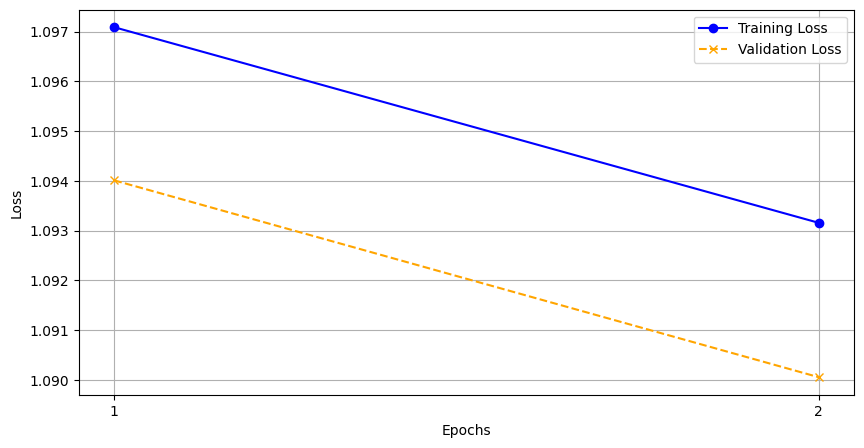

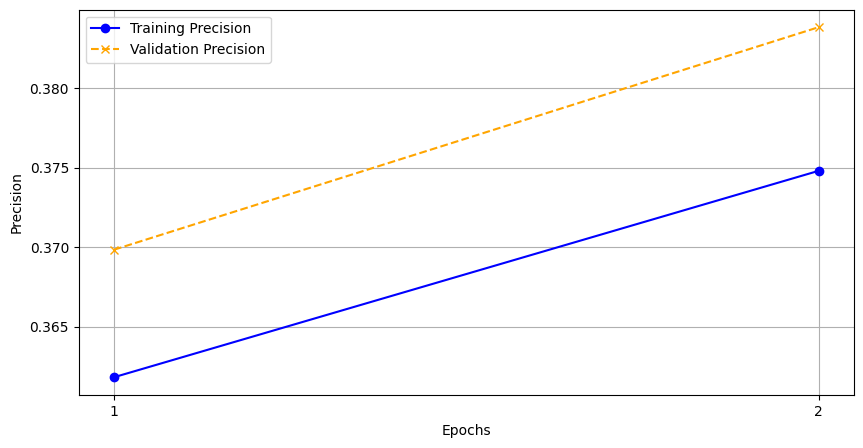

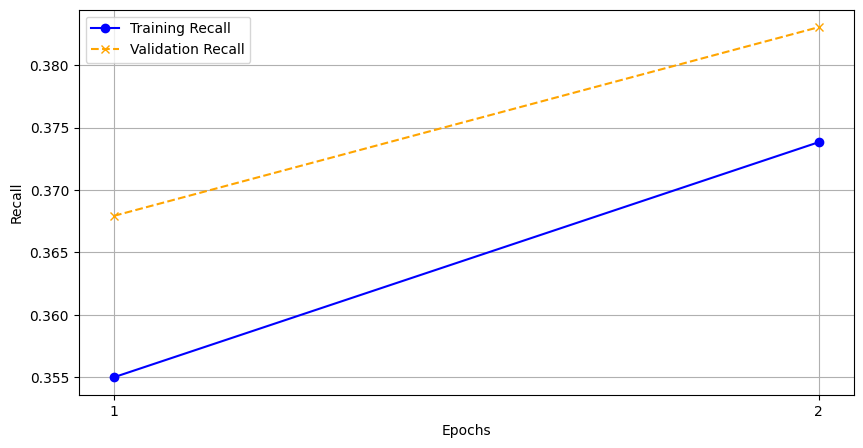

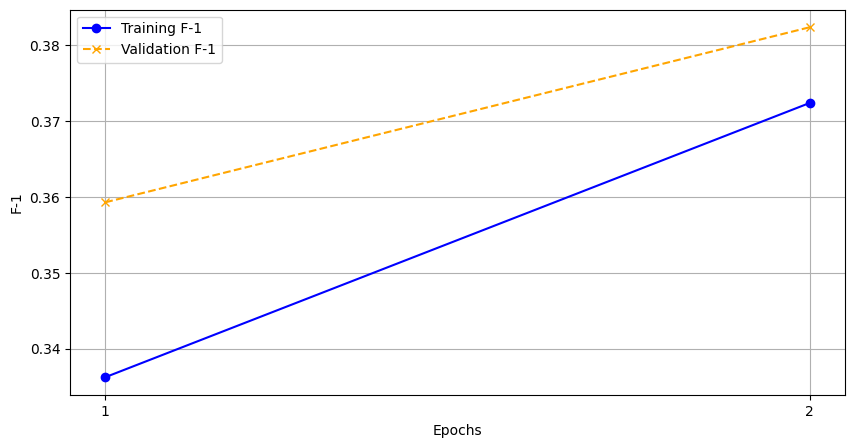

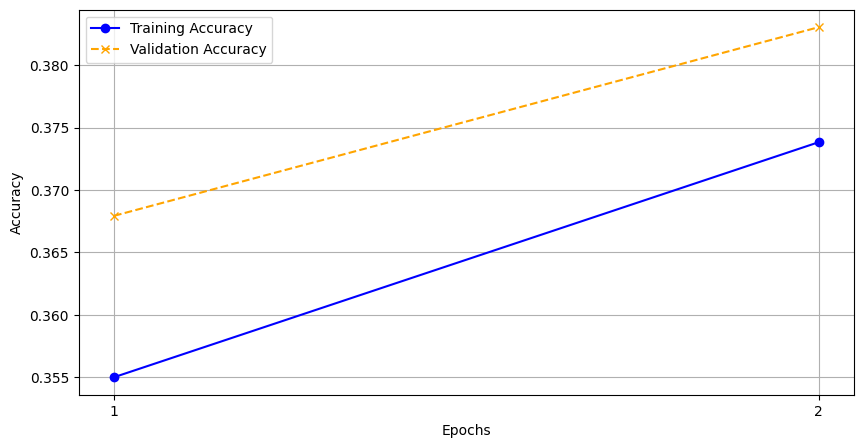

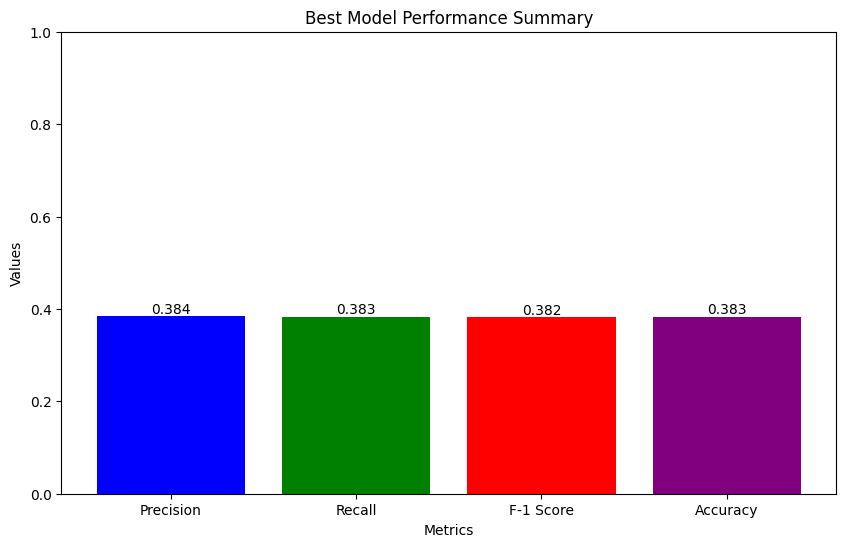

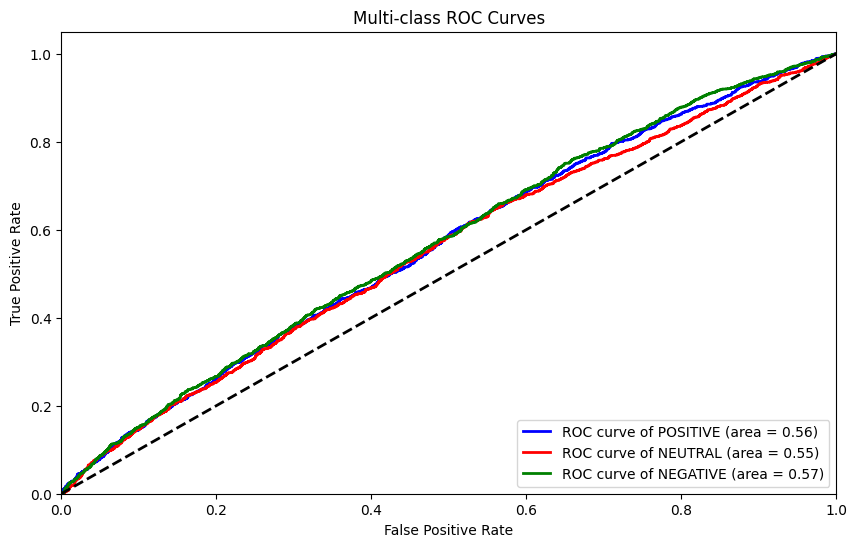

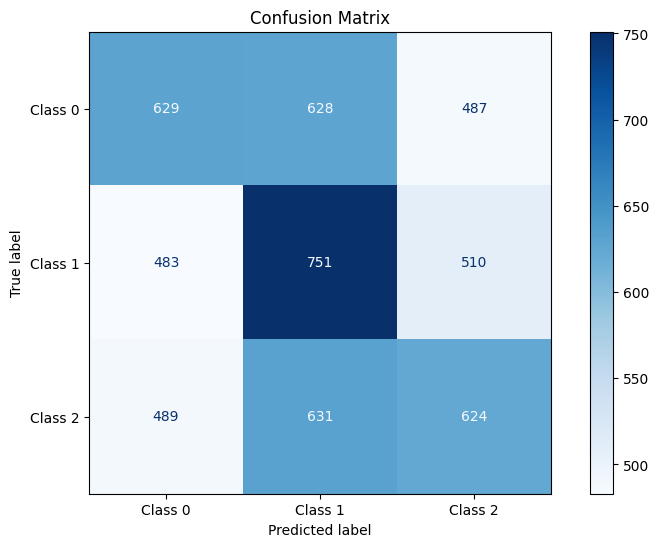

In [95]:
 # NEURAL NETWORK TRAINING

(metrics, labels_and_predictions, probabilities,best_model_metrics) = neural_network.train_model(train_loader,valid_loader,hyperparameters['training'])
plots = Plot.plot_all(metrics,labels_and_predictions,probabilities,best_model_metrics)

#Save.save_plots(plots,input_size,hyperparameters,best_model_metrics)

In [96]:
# NEURAL NETWORK PREDICTIONS

test_set_predictions = neural_network.predict(test_loader)
test_set_predictions = preprocessor.encode_sentiments(test_set_predictions,to_numbers=False)

In [97]:
# PREDICTION SAVING

Save.save_predictions(test_set_url,test_set_predictions)